# Lecture 1: floating point
### Sasha Tchekhovskoy

## import useful libraries

In [3]:
#import ctypes
#from ctypes import *
#from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
#import numba

## adjust fonts and font sizes

In [55]:
import matplotlib as mpl
from matplotlib import rc

#choose Computer Modern Roman fonts by default
mpl.rcParams['font.serif'] = 'cmr10'
mpl.rcParams['font.sans-serif'] = 'cmr10'
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.handlelength'] = 2
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus']=False
#uncomment these two lines and rerun the notebook
#before exporting as PDF for high-quality plots
#mpl.rcParams['figure.figsize'] = (8, 4)
#mpl.rcParams['figure.dpi'] = 300

# Is sin(pi) zero?

In [82]:
f = np.sin(np.pi)
print("sin(pi) = %g" % f)
print("Is it zero?")
if 0 == f: print("Yes!")
else: print("No")

sin(pi) = 1.22465e-16
Is it zero?
No


## smallest values that floating point can resolve relative to unity

In [4]:
eps_float32 = np.finfo(np.float32).eps
eps_float64 = np.finfo(np.float64).eps
print(r"eps(float32) = %g" % eps_float32)
print(r"eps(float64) = %g" % eps_float64)

eps(float32) = 1.19209e-07
eps(float64) = 2.22045e-16


## epsilon is the smallest number resolvable relative to unity

In [10]:
f1 = 1.0 + eps_float64
f2 = 1.0 + eps_float64/2
print(f1 == 1)
print(f2 == 1)

False
True


In [103]:
maxn = 100
xold = 2.
xnew = 1.
for n in np.arange(maxn):
    xbackup = xnew
    xnew = xnew/2
    xold = xbackup
    if 1.+xnew == 1.:
        break
print("machine epsilon = %g" % xold)
print(xnew)
print(xold)
print(np.finfo(np.float64))
print(2**-23*2**-127)

machine epsilon = 2.22045e-16
1.1102230246251565e-16
2.220446049250313e-16
Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------

7.006492321624085e-46


## Exercise 1: compute eps_float64

# Numerical derivatives
## Exercise 2: Numerically compute the derivative of $sin(x)$ and the error $\epsilon$ by comparing to the analytic solution. How does the error scale with $h$? For this, plot $\epsilon$ vs $h$ on a log-log plot and determine the slope.

# Let's solve some OEs!
## Nuclear decay as an example, using RK23 and RK45

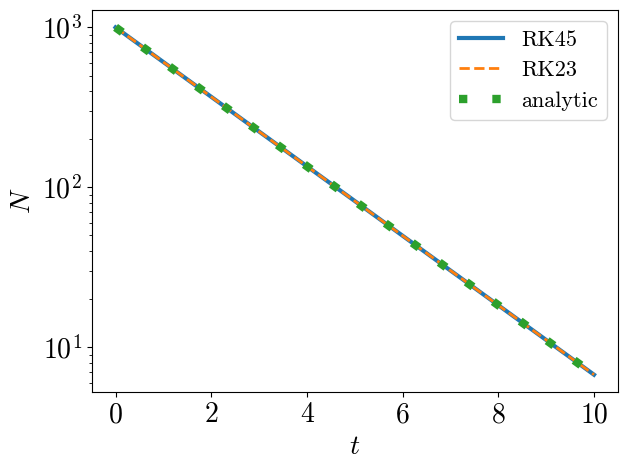

In [125]:
import numpy as np
from scipy.integrate import solve_ivp
def exponential_decay(t, y): return -0.5 * y
sol45 = solve_ivp(exponential_decay, [0, 10], [1e3],method='RK45',max_step = 0.01)
sol23 = solve_ivp(exponential_decay, [0, 10], [1e3],method='RK23',max_step = 0.01)
plt.plot(sol45.t,sol45.y.T,label="RK45",lw=3)
l,=plt.plot(sol23.t,sol23.y.T,"--",label="RK23",lw=2)
l2,=plt.plot(sol23.t,1e3*np.exp(-sol23.t/2),lw=6,label="analytic")
l2.set_dashes([1,3])
plt.yscale("log")
plt.ylabel(r"$N$",fontsize=20)
plt.xlabel(r"$t$",fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig("decay.pdf")

## Exercise 3: How does the error scale with $\Delta t$? For this, plot the error vs $\Delta t$ on a log-log plot and determine the slope.

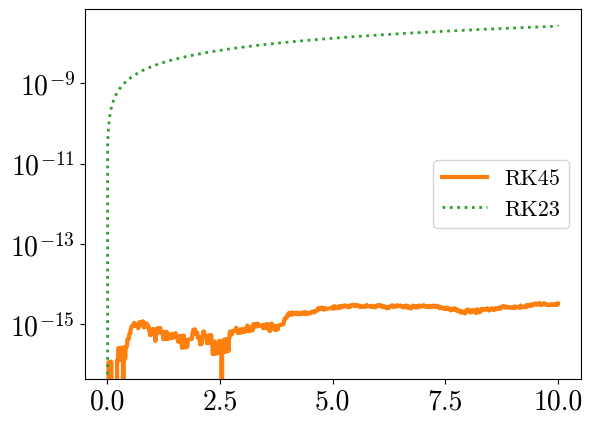

In [127]:
fa = lambda t: 1e3*np.exp(-t/2)
plt.plot(sol45.t,np.abs(sol45.y[0]-fa(sol45.t))/fa(sol45.t),label="RK45",lw=3,color="C1")
plt.plot(sol23.t,np.abs(sol23.y[0]-fa(sol23.t))/fa(sol23.t),":",label="RK23",lw=2,color="C2")
plt.yscale("log")
plt.legend()

# Let's solve wave equation:
# $$\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}$$

In [9]:
from numba import jit, njit
@jit
def integrate_wave(y0, y1, y2, nx, rsq, nsteps, y_dump):
    y_dump[0,:] = y1[:]
    nstep_dump = nsteps//(y_dump.shape[0]-1)
    for n in np.arange(1,nsteps+1):
        for i in np.arange(1,nx+1):
            y2[i] = 2*(1-rsq)*y1[i]-y0[i]+rsq*(y1[i+1]+y1[i-1])
        #update the time
        ytemp = y0
        y0 = y1
        y1 = y2
        y2 = ytemp
        #save the solution every nstep_dump
        if n % nstep_dump == 0:
            y_dump[n//nstep_dump,:] = y1[:]
    return

#plot solution for each dump
def plot_solution(x,y_dump):
    for dump_number,y in enumerate(y_dump):
        plt.clf()
        plt.xlim(0,1)
        plt.ylim(-1,1)
        plt.plot(x,y)
        plt.savefig("dump%04d.png" % dump_number)
    return

In [ ]:
import time
#parameters
#resolution
nx = 1000-1
#length of the string
L = 1
#sound speed
c = 300
#Courant factor
r = 1.
#final time
tf = 2.5*L/c
#number of dumps
total_dumps = 100
#initial conditions
k = 1000
x0 = 0.3
y_initial = lambda x: np.exp(-k*(x-x0)**2)
#generate grid
x = np.linspace(0,1,nx+2)*L
dx = x[1]-x[0]
rsq = r*r
dt = r*dx/c
nsteps = np.int64(tf/dt+0.5)
###
y0 = np.zeros([nx+2],dtype=np.float64)
y1 = np.zeros([nx+2],dtype=np.float64)
y2 = np.zeros([nx+2],dtype=np.float64)
y_dump = np.zeros([total_dumps+1,nx+2],dtype=np.float64)
#initial conditions
y0[1:-1] = y_initial(x[1:-1])
y1[:] = y0[:]
start = time.time()
integrate_wave(y0, y1, y2, nx, rsq, nsteps, y_dump)
end = time.time()
print(end - start)
plot_solution(x,y_dump)

# Let's solve random walk in 1D: molecules jumps with probability $p$ to the left and with the same probability $p$ to the right. How does the number distribuion of molecules change in time? 


In [193]:
#plot solution for each dump
def plot_analytic_solution_rw(x, t, D, sigma0, dump_number):
    y_initial = lambda x,x0,sigma0: (1./sigma0/(2*np.pi)**0.5)*np.exp(-0.5*(x-x0)**2/sigma0**2)
    sigma_t = lambda t,D,sigma0: (sigma0**2+(2*D*t))**0.5
    l,=plt.plot(x,y_initial(x,0,sigma_t(t,D,sigma0)),label="analytical",lw=4)
    l.set_dashes([2,3])
    plt.xlim(-0.5*L,0.5*L)
    plt.legend()
    plt.ylabel(r"$\rho$",fontsize=20,labelpad=-1)
    plt.xlabel(r"$x$",fontsize=20,labelpad=-7)
    plt.title(r"$t=%3.1f$" % t)
    #plt.tight_layout()
    plt.savefig("dump_rw_%04d.png" % dump_number)

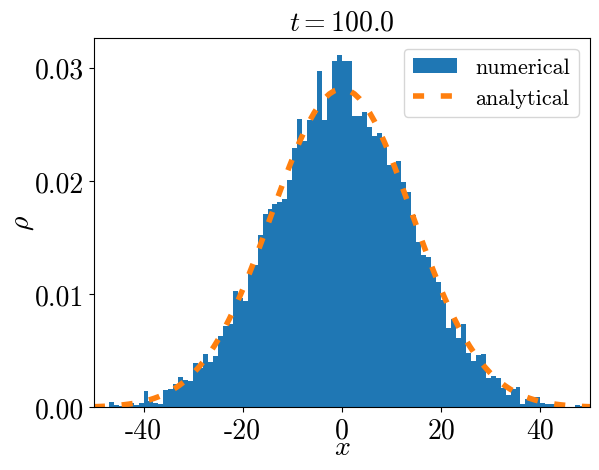

In [194]:
#from random import random

N_points = 10000
#number of dumps
total_dumps = 100
#final time
tf = 100.
#effective dt
dt = 0.1
#jump distance
dx = 1.
#number of steps
N_steps = tf/dt
#number of bins
n_bins = 100
#size of domain
L = 100
#probability of jumping left or right (probability of staying at the same place, p_stay = 1-2*p)
prob = 0.1
# Create a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(19680801)
#
#dist = np.zeros([N_points],dtype = np.float64)
dist = rng.standard_normal(N_points)
x = np.linspace(-0.5*L,0.5*L,n_bins)
#res = plt.hist(dist, bins=n_bins, density=True,range=(-50,50))
D = prob*dx**2/dt
sigma0 = 1.
#plot at initial time
plt.clf()
res = plt.hist(dist, bins=n_bins, density = True,range=(-0.5*L,0.5*L),label="numerical")
t = 0
dump_number = 0
plot_analytic_solution_rw(x, t, D, sigma0, dump_number)
#
for n in np.arange(1,N_steps+1):
    for i in np.arange(N_points):
        f = rng.random()
        if f <= prob:
            dist[i] -= dx
        elif f <= 2*prob:
            dist[i] += dx
    if n % (N_steps//total_dumps) == 0:
        dump_number = n // (N_steps//total_dumps)
        plt.clf()
        res = plt.hist(dist, bins=n_bins, density = True,range=(-0.5*L,0.5*L),label="numerical")
        t = n*dt
        plot_analytic_solution_rw(x, t, D, sigma0, dump_number)


# Let's solve diffusion equation:
# $$\frac{\partial y}{\partial t} = D \frac{\partial^2 y}{\partial x^2}$$

In [191]:
from numba import jit, njit
@jit
def integrate_diffusion(y0, y1, nx, r, nsteps, y_dump):
    y_dump[0,:] = y0[:]
    nstep_dump = nsteps//(y_dump.shape[0]-1)
    for n in np.arange(1,nsteps+1):
        for i in np.arange(1,nx+1):
            y1[i] = y0[i]+r*(y0[i+1]+y0[i-1]-2*y0[i])
        #update the time
        ytemp = y0
        y0 = y1
        y1 = ytemp
        #save the solution every nstep_dump
        if n % nstep_dump == 0:
            y_dump[n//nstep_dump,:] = y0[:]
    return

y_initial = lambda x,x0,sigma0: (1./sigma0/(2*np.pi)**0.5)*np.exp(-0.5*(x-x0)**2/sigma0**2)
sigma_t = lambda t,D,sigma0: (sigma0**2+(2*D*t))**0.5 #(2*D*(t+0.5*sigma0**2/D))**0.5

#plot solution for each dump
def plot_solution_diffusion(x,y_dump,t_dump, D, sigma0):
    for dump_number,y in enumerate(y_dump):
        plt.clf()
        plt.xlim(x[0],x[-1])
        #plt.ylim(-1,1)
        plt.plot(x,y,label="numerical",lw=2)
        l,=plt.plot(x,y_initial(x,0,sigma_t(t_dump[dump_number],D,sigma0)),label="analytical",lw=4)
        l.set_dashes([2,3])
        plt.legend()
        plt.ylabel(r"$\rho$",fontsize=20,labelpad=-1)
        plt.xlabel(r"$x$",fontsize=20,labelpad=-7)
        plt.title(r"$t=%3.1f$" % t_dump[dump_number])
        #plt.tight_layout()
        plt.savefig("dump_diffusion_%04d.png" % dump_number)
    return

0.25168299674987793


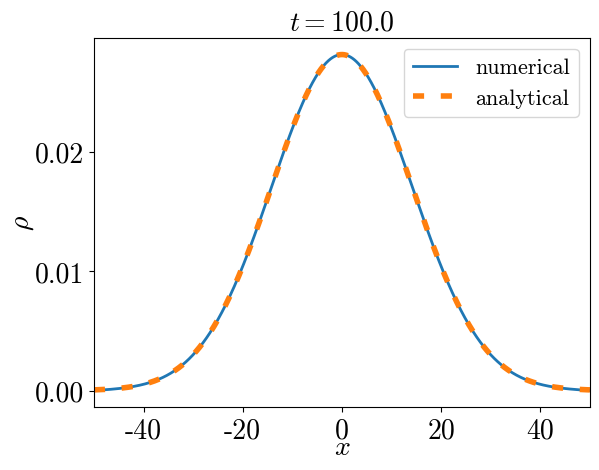

In [192]:
import time
#parameters
#resolution
nx = 1000-1
#length of the string
L = 100.
#Dispersion coefficient
D = 1.
#Courant factor
r = 0.25
#final time
tf = 100.
#number of dumps
total_dumps = 100
#initial conditions
sigma0 = 1.
x0 = 0.
#generate grid
x = np.linspace(-1.,1.,nx+2)*0.5*L
dx = x[1]-x[0]
dt = r*dx**2/D
nsteps = np.int64(tf/dt+0.5)
###
y0 = np.zeros([nx+2],dtype=np.float64)
y1 = np.zeros([nx+2],dtype=np.float64)
y_dump = np.zeros([total_dumps+1,nx+2],dtype=np.float64)
t_dump = np.zeros([total_dumps+1],dtype=np.float64)
#initial conditions
y0[1:-1] = y_initial(x[1:-1],0,sigma0)
start = time.time()
integrate_diffusion(y0, y1, nx, r, nsteps, y_dump)
t_dump = np.linspace(0,tf,y_dump.shape[0])
end = time.time()
print(end - start)
plot_solution_diffusion(x,y_dump,t_dump,D=D,sigma0=sigma0)